#### Exercise 8 - Solution - Event Study Time Varying Coefficients 

In Aug 2024, Starbucks announced a CEO change without any other materially confounding information (e.g. it wasn't along an earnings report). Events like these are something companies and investors are regularly interested in quantifying impact -- but naturally don't want to design an experiment randomly giving users bad experiences

Examples of how this might transfer: Suppose there is an outage that affects a certain region or population of users (iOs but not Android, NYC but not San Francisco or LA, purchasers of product X but not Y, etc.). If you have a time series of performance by these groups, you may consider these models to estimate the impact.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
event_date = '2024-08-13'
prices = pd.read_csv('../../Exercise7-event-study/data/sbux_ceo_prices.csv')
prices = prices[prices['returns'].isnull()==0].copy()
print(prices['date'].agg(['min','max']))
prices.head()

min    2024-01-03
max    2024-08-30
Name: date, dtype: object


,date,open,high,low,close,adjclose,volume,ticker,returns
1,2024-01-03,93.959999,94.239998,93.059998,93.230003,89.737869,7161700,SBUX,-0.004697
2,2024-01-04,93.099998,94.580002,93.000000,93.550003,90.045891,7118600,SBUX,0.003432
3,2024-01-05,93.330002,93.580002,92.480003,92.989998,89.506851,7189900,SBUX,-0.005986
4,2024-01-08,93.019997,94.570000,92.949997,94.190002,90.661919,7536900,SBUX,0.012905
5,2024-01-09,93.610001,93.730003,92.860001,93.089996,89.603111,6348500,SBUX,-0.011679


### Estimate event study model

In [9]:
df_wide = prices.pivot(index='date', columns='ticker', values='returns')
df_wide.reset_index(inplace=True)
df_wide.columns.name = None
df_wide['date'] = pd.to_datetime(df_wide['date'])

# We do not have one observation per date, so get a trend variable 
# that moves in increments of one for each trading date
df_wide['t'] = range(1, len(df_wide) + 1)
event_index = df_wide.loc[df_wide['date'] == event_date, 't'].values[0]
df_wide['trend'] = df_wide['t'] - event_index

df_wide.head()

,date,MCD,SBUX,VOO,YUM,t,trend
0,2024-01-03,-0.008921,-0.004697,-0.007419,0.000543,1,-153
1,2024-01-04,-0.009002,0.003432,-0.003157,-0.003176,2,-152
2,2024-01-05,-0.009426,-0.005986,0.001281,-0.002720,3,-151
3,2024-01-08,0.010070,0.012905,0.014303,0.002338,4,-150
4,2024-01-09,-0.003529,-0.011679,-0.002430,-0.003265,5,-149


In [11]:
preperiod_days = 90
postperiod_days = 1

df = df_wide[(df_wide['trend'] >= -1*preperiod_days) & (df_wide['trend'] < postperiod_days)].copy()
df['event'] = np.where(df['trend']==0,1,0)

formula = 'SBUX~MCD+VOO+YUM+event'
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     39.13
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           1.25e-18
Time:                        19:15:45   Log-Likelihood:                 223.39
No. Observations:                  91   AIC:                            -436.8
Df Residuals:                      86   BIC:                            -424.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0011      0.002     -0.480      0.6

In [13]:

preperiod_days = 90
postperiod_days = 4

df = df_wide[(df_wide['trend'] >= -1*preperiod_days) & (df_wide['trend'] < postperiod_days)].copy()

df['pre1'] = df['trend'].apply(lambda x: 1 if x == -1 else 0)
df['pre2'] = df['trend'].apply(lambda x: 1 if x == -2 else 0)
df['pre3'] = df['trend'].apply(lambda x: 1 if x == -3 else 0)
df['post0'] = df['trend'].apply(lambda x: 1 if x == 0 else 0)
df['post1'] = df['trend'].apply(lambda x: 1 if x == 1 else 0)
df['post2'] = df['trend'].apply(lambda x: 1 if x == 2 else 0)
df['post3'] = df['trend'].apply(lambda x: 1 if x == 3 else 0)

formula = 'SBUX~MCD+VOO+YUM+pre3+pre2+pre1+post0+post1+post2+post3'
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   SBUX   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     16.10
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           1.14e-15
Time:                        19:17:01   Log-Likelihood:                 233.98
No. Observations:                  94   AIC:                            -446.0
Df Residuals:                      83   BIC:                            -418.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0014      0.002     -0.626      0.5

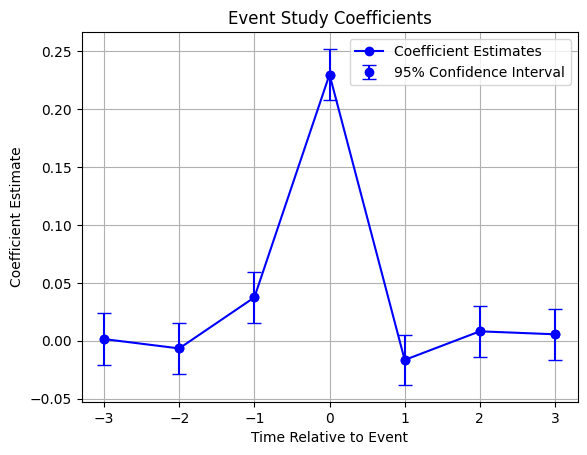

In [14]:
# Extract coefficients for pre3, pre2, pre1, post0, post1, post2, and post3
coefficients = ['pre3', 'pre2', 'pre1', 'post0', 'post1', 'post2', 'post3']
x_values = range(-3, 4)  # x values from -3 to +3
y_values = [model.params[coef] for coef in coefficients]

# Add error bars using standard errors from model.bse
y_errors = [model.bse[coef] for coef in coefficients]

# Plot the coefficient estimates as a connected line graph
plt.plot(x_values, y_values, marker='o', color='b', label='Coefficient Estimates')

# Add error bars to the plot
plt.errorbar(x_values, y_values, yerr=y_errors, fmt='o', color='b', capsize=5, label='95% Confidence Interval')
plt.title('Event Study Coefficients')
plt.xlabel('Time Relative to Event')
plt.ylabel('Coefficient Estimate')
plt.xticks(x_values)
plt.legend()
plt.grid(True)
plt.show()